In [7]:
!pip install networkx

# Import dependencies

In [48]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages graphframes:graphframes:0.8.1-spark3.0-s_2.12 pyspark-shell'

from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
from pyspark.sql.types import Row
from graphframes import *
import networkx as nx
import matplotlib.pyplot as plt

sc = SparkContext.getOrCreate()
spark = SparkSession(sc)

In [35]:
def PlotGraph(edge_list):
    Gplot=nx.DiGraph()
    for row in edge_list.select('src','dst').take(1000):
        Gplot.add_edge(row['src'],row['dst'])

#     plt.subplot(121)
#     plt.figure(figsize=(10, 10))
    nx.draw(Gplot, with_labels=True, font_weight='bold')

In [36]:
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 37),
  ("d", "David", 29),
  ("e", "Esther", 32),
  ("f", "Fanny", 38),
  ("g", "Gabby", 60)
], ["id", "name", "age"])

# Edges DataFrame
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
  ("f", "c", "follow"),
  ("e", "f", "follow"),
  ("e", "d", "friend"),
  ("d", "a", "friend"),
  ("a", "e", "friend"),
  ("g", "e", "follow")
], ["src", "dst", "relationship"])

# Create a GraphFrame
g = GraphFrame(v, e)

g.vertices.show()
g.edges.show()

+---+-------+---+
| id|   name|age|
+---+-------+---+
|  a|  Alice| 34|
|  b|    Bob| 36|
|  c|Charlie| 37|
|  d|  David| 29|
|  e| Esther| 32|
|  f|  Fanny| 38|
|  g|  Gabby| 60|
+---+-------+---+

+---+---+------------+
|src|dst|relationship|
+---+---+------------+
|  a|  b|      friend|
|  b|  c|      follow|
|  c|  b|      follow|
|  f|  c|      follow|
|  e|  f|      follow|
|  e|  d|      friend|
|  d|  a|      friend|
|  a|  e|      friend|
|  g|  e|      follow|
+---+---+------------+



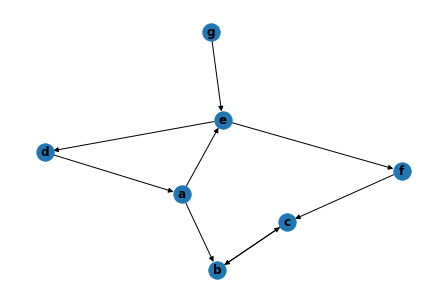

In [37]:
PlotGraph(g.edges)

## Question 1
Write code to perform the following tasks using GraphFrames:

Find Alice's two-hop neighbors' names, regardless of the edge type.

In [22]:
friends = g.find("(a)-[]->(b);(b)-[]->(c)").filter("a.name='Alice'")
friends.select('c').collect()

[Row(c=Row(id='f', name='Fanny', age=38)),
 Row(c=Row(id='d', name='David', age=29)),
 Row(c=Row(id='c', name='Charlie', age=37))]

# Question 2

Redo the previous question, but exclude Alice's two-hop neighbors who have an edge back to Alice.

In [29]:
friends = g.find("(a)-[]->(b);(b)-[]->(c);(c)-[]->(a)").filter("a.name='Alice'")
friends.select('c').collect()

[Row(c=Row(id='d', name='David', age=29))]

# Question 3

Find all people who follow Charlie.

Hint: Use AND in SQL, or (..) & (..) in DataFrame boolean expressions.

In [34]:
followers = g.find("(a)-[e]->(b)").filter("b.name='Charlie' AND e.relationship='follow' ")
followers.select('a').show()

+--------------+
|             a|
+--------------+
|[f, Fanny, 38]|
|  [b, Bob, 36]|
+--------------+



# Question 4

Find all people who are being followed by at least 2 people.

In [47]:
g.edges.filter(g.edges.relationship == 'follow').groupby('dst').count().filter("count>=2").show()

+---+-----+
|dst|count|
+---+-----+
|  c|    2|
+---+-----+



# Question 5

Create a queue of 10 RDDs using this data set and feed it into a Spark Streaming program.  Your Spark Streaming algorithm should maintain a state that keeps track of the longest noun seen so far associated with each distinct adjective. After each RDD, print any 5 adjectives and their associated longest nouns, as well as the longest noun associated with the adjective 'good'. Note that not every line in the data set contains exactly two words, so make sure to clean the data as they are fed into the streaming program.  The skeleton code is provided below:


```python

from pyspark.streaming import StreamingContext

ssc = StreamingContext(sc, 5)
# Provide a checkpointing directory. Required for stateful transformations
ssc.checkpoint("checkpoint")

numPartitions = 8
rdd = sc.textFile('../data/adj_noun_pairs.txt', numPartitions)
rddQueue = rdd.randomSplit([1]*10, 123)
lines = ssc.queueStream(rddQueue)

# FILL IN YOUR CODE

ssc.start()
ssc.awaitTermination(50)
ssc.stop(False)
print("Finished")
```

In [49]:
from pyspark.streaming import StreamingContext

ssc = StreamingContext(sc, 5)
# Provide a checkpointing directory. Required for stateful transformations
ssc.checkpoint("checkpoint")

numPartitions = 8
rdd = sc.textFile('adj_noun_pairs.txt', numPartitions)
rddQueue = rdd.randomSplit([1]*10, 123)
lines = ssc.queueStream(rddQueue)



ssc.start()
ssc.awaitTermination(10)
ssc.stop(False)
print("Finished")

IllegalArgumentException: requirement failed: No output operations registered, so nothing to execute